In [2]:
import os
import json
import numpy as np
from eval_utils import load_setup, calculator, extract_deal

To run this code, the following things must be taken into consideration:

- The necessary history files can be found inside each of the 'game_descriptions' directories, inside the 'output' directory.
- The code evaluates the history files that come from the output of each individual model. OUTPUT_DIR must be set to the path of the directory containing these files. For example, './games_descriptions/base/output/gpt4o_mini/all_coop/multi_agent/row5'. Configuring the OUTPUT_DIR checks the history files of the experiment with GPT-4o-Mini, using an all cooperative multi-agent setup and a row5 from table5 CoT structure.
- AGENT_NAME changes according to the game played. Set these value accordingly. Any player and role can be used. However, to select the P1 player for each of the game configurations, which can be found on their config.txt files, the variable must be set to one of the following:
    - Base: 'SportCo'
    - Game1: 'government'
    - Game2: 'Project manager'
    - Game3: 'Private investors'
- For all of our experiments, AGENTS_NUM and ISSUES_NUM never changed from 6 and 5 respectively.
- For all of the multiple agents configurations, NUM_ROUNDS is always set equal to 24. However, for the single agent configuration, most of the experiments have 6 rounds while gpt-4o-mini may have others with 24. Please take this into consideration and set SINGLE_AGENT to True.
- The SINGLE_CALL and SINGLE_CALL_ROUNDS are meant to be used only when SINGLE_AGENT is True. These are used to check the performance of the model on only a specific amount of rounds, instead of using the whole run. This works to configure the 'Single Agent N call' setup.

In [3]:

HOME = '../'
HOME = '/Users/mashsmash/'

# Output directory to be analyzed
OUTPUT_DIR = os.path.join(HOME,'games_descriptions/base/output/qwen_2_5_32b/all_coop/multi_agent/row5')
OUTPUT_DIR = os.path.join(HOME, 'uva/fact/final_res/llm_negotiation/games_descriptions/base/output/qwen_2_5_32b/all_coop/multi_agent/row5')

# Setup variables
AGENT_NAME = 'SportCo'
AGENTS_NUM = 6
ISSUES_NUM = 5
NUM_ROUNDS = 24 # check the "rounds_number" value at the end of the history file
SINGLE_AGENT = False

# Only works for SINGLE_AGENT = True
SINGLE_CALL = False
SINGLE_CALL_ROUNDS = 1


## Read scores and config files and logs from experiment dir 

In [4]:
agents, role_to_agents, incentive_to_agents = load_setup(OUTPUT_DIR, AGENTS_NUM, ISSUES_NUM)
answers_files = [ os.path.join(OUTPUT_DIR, filename) for filename in os.listdir(OUTPUT_DIR) if filename.startswith("history")]

print(agents.keys())

dict_keys(['Mayor', 'Other cities', 'Local Labour Union', 'SportCo', 'Department of Tourism', 'Environmental League'])


In [5]:
def loop_all_parties(agents, deal, veto_parties):
    '''
    loop over all parties and calculate sum of scores for a particular deal made by any agent at any point 
    calculate number of agreeing parties
    return whether veto parties agreed 
    
    Returns:
        - number of agreeing parties 
        - whether veto parties agree 
        - a list of scores of parties for that deal 
    '''
    agreed = 0 
    veto_agreed = [False for _ in veto_parties]
    all_parties_score = []

    for name_i in agents.keys():
        party_score = calculator(agents[name_i]['scores'], deal, ISSUES_NUM) 
        all_parties_score.append(party_score)
        if party_score > agents[name_i]['scores']['min']: 
            agreed += 1 
            if name_i in veto_parties: veto_agreed[veto_parties.index(name_i)] = True 
                
    return agreed, veto_agreed, all_parties_score

In [6]:
def check_correctness(agents, agent_name, p1, deal, veto_agreed, wrong_suggested):
    '''
    check if a deal is valid wrt the min score of the agent 
    if the agent is p1 and (deal_value+10) > threshold, consider it valid and correct veto_agreed 
    returns:
        updated value of wrong suggested 
        updated veto_agreed 
    '''
    
    deal_value =  calculator(agents[agent_name]['scores'],deal,ISSUES_NUM) 
    
    if deal_value < agents[agent_name]['scores']['min']: 
        if agent_name == p1 and (deal_value + 10) >= agents[agent_name]['scores']['min']:
            veto_agreed[0] = True
        else:
            # not p1 
            # p1 and not (deal_value+10) > thresholds (to accomodate the bonus rule)
            wrong_suggested += 1 
    return wrong_suggested, veto_agreed

In [7]:
def check_agreement(agents, p1, agreed, veto_agreed, deal):
    '''
    check if current deal leads to agreement (by a deal made by p1)
    
    if all party agrees and (deal_value+10) >= min score of p1 -> all agreement, deal is done (ANY metric)
    
    if 4 party agree including p2 and >= min -> 5 way agreement, deal is done (ANY metric)
    
    
    Returns:
        - whether a deal can be done based on this current round 
        - whether there is all_agreement
    '''
    
    deal_value =  calculator(agents[p1]['scores'], deal, ISSUES_NUM) 
    # print('----')
    # print(agreed)
    # print(veto_agreed)
    # print(AGENTS_NUM)
    # print(deal_value)
    # print(agents[p1]['scores']['min'])
    # print('----')

    curr_round_deal_done = False 
    all_agreement = False 
    
    if agreed == AGENTS_NUM: 
        curr_round_deal_done = True 
        all_agreement = True        
    
    elif agreed == (AGENTS_NUM-1) and (not veto_agreed[0]) and ( (deal_value+10) >= agents[p1]['scores']['min'] ):
        #p1 not met but would be met with +10 rule  
        print(deal)
        curr_round_deal_done = True 
        all_agreement = True
        
    elif agreed == (AGENTS_NUM-1) and all(veto_agreed): 
        #one other party was excluded. 
        curr_round_deal_done = True 

        
    return curr_round_deal_done,all_agreement

In [8]:
def gini_coefficient(values):
    """
    Parameters:
    values (list or numpy array): A list or array of numerical values (e.g., gains of agents).
    Returns:
    float: Gini coefficient, ranging from 0 (perfect equality) to 1 (maximum inequality).
    """
    if not values or len(values) == 0:
        raise ValueError("The list of values must not be empty.")

    values = np.array(values, dtype=np.float64)
    n = len(values)
    mean_value = np.mean(values)

    if mean_value == 0:
        return 0.0  #avoid division by zero

    #sum of absolute differences
    absolute_differences_sum = sum(abs(values[i] - values[j]) for i in range(n) for j in range(n))
    #gini coefficient formula
    gini = absolute_differences_sum / (2 * n**2 * mean_value)

    return gini

In [9]:
def coefficient_of_variation(values):
    """
    Compute the Coefficient of Variation (CV) for a list or numpy array of values.

    The CV is defined as the ratio of the standard deviation to the mean:
    CV = sigma / mean

    Parameters:
    values (list or numpy array): A list or array of numerical values.

    Returns:
    float: Coefficient of Variation (CV), or None if mean is zero.
    """
    if not values or len(values) == 0:
        raise ValueError("The list of values must not be empty.")

    values = np.array(values, dtype=np.float64)
    mean_value = np.mean(values)
    std_dev = np.std(values)

    if mean_value == 0:
        return None  #undefined if the mean is zero

    cv = std_dev / mean_value
    return cv

In [10]:

def get_metrics(agents, answers, veto_parties, num_rounds, prompts=[], single_agent=False, single_call=False):
    
    '''
    compute metrics for one negotiation session
    '''

    deal_values_per_agents = {name_:[] for name_ in agents.keys()} 
    wrong_suggested = 0 
    all_deals_count = 0 
    deal_done = False
    
    p1 = veto_parties[0]
    
    # rounds should be number of rounds + 2 (start and final deal suggestion)
    expected_rounds = num_rounds + (1 if single_agent else 2)
    if len(answers['rounds']) != expected_rounds:
        return
    
    answer_rounds = answers['rounds'][:SINGLE_CALL_ROUNDS+1] if single_call else answers['rounds']
    
    for round_ in answer_rounds:
        name, answer = round_['agent'], round_['public_answer']
        deal, issues_suggested = extract_deal(answer, round_['full_answer'], ISSUES_NUM, True)
        prompts.append(round_['prompt'])

        if issues_suggested < ISSUES_NUM: 
            continue
            
        veto_agreed = [False for _ in range(len(veto_parties))]
        
        all_deals_count += 1 
        
        agreed, veto_agreed, all_parties_score = loop_all_parties(agents, deal, veto_parties)

        wrong_suggested, veto_agreed = check_correctness(agents,name, p1,deal,veto_agreed,wrong_suggested)
        
        if name == p1: 
            curr_deal_done, all_agreement = check_agreement(agents,p1,agreed,veto_agreed,deal)
        
        deal_done = curr_deal_done or deal_done
        
        deal_value = calculator(agents[name]['scores'],deal,ISSUES_NUM)
        deal_values_per_agents[name].append([deal_value,agreed,all_parties_score])
    
    print('Final deal: ' + ', '.join(deal))
    
    '''
    returns 
        - wrong_suggested/all_deals_count (ratio of wrong suggested deals)
        - deal_done (whether a deal has been done in any round by p1)
        - all_agreement (whether the final deal by p1 led to all agreement)
        - curr_deal_done (whether the final deal by p1 led to an agreement)
        - deal_values_self: a dict of agents and their suggested deals: value to themselves, number of agreeing, average score of parties
    '''
    return wrong_suggested / all_deals_count, deal_done, all_agreement, curr_deal_done, deal_values_per_agents

## Metrics: ratios of: 
#### - agreement at any round by p1
#### - final 5/6-way agreement by p1 
#### - final 6-way agreement by p1 
#### - wrong deals

In [11]:
'''
Loop over all sessions and aggregate metrics 
'''

prompts = []
wrong_suggested, deal_done, all_agreement, deal_final_round, deal_values_per_agents, gini_values, coefs_of_variations = [], [], [], [], [], [], []
for file_ in answers_files:

    answers = json.load(open(file_))
    metrics =  get_metrics(agents, answers, [role_to_agents['p1'], role_to_agents['p2']], NUM_ROUNDS, prompts, SINGLE_AGENT, SINGLE_CALL)

    if metrics: 
        wrong_suggested.append(metrics[0])
        deal_done.append(metrics[1])
        all_agreement.append(metrics[2])
        deal_final_round.append(metrics[3])
        deal_values_per_agents.append(metrics[4])

        final_deal_values = metrics[4][AGENT_NAME][-1][-1]
        gini = gini_coefficient(final_deal_values)
        gini_values.append(gini)
        cov = coefficient_of_variation(final_deal_values)
        coefs_of_variations.append(cov)

print('Percentage of achieved deals at any round: '+ str(sum(deal_done)/len(deal_done)))
print('Percentage of achieved deals at the last round: '+ str(sum(deal_final_round)/len(deal_final_round)))
print('Percentage of achieved deals with all agreement at the last round: '+ str(sum(all_agreement)/len(all_agreement)))
print('Percentage of deals violating rules: '+ str(np.mean(wrong_suggested)))
print('Avg. Gini Coefficient of final deals: '+ str(np.mean(gini_values)))
print('Avg. Coefficient of Variation of final deals: '+ str(np.mean(coefs_of_variations)))

print(len(wrong_suggested))

Final deal: A2, B3, C3, D2, E3
Final deal: A2, B3, C3, D2, E4
Final deal: A2, B3, C2, D1, E2
Final deal: A2, B2, C2, D3, E2
Final deal: A2, B2, C2, D2, E4
Final deal: A2, B3, C2, D3, E2
Final deal: A2, B3, C3, D2, E3
Final deal: A2, B3, C2, D1, E2
Final deal: A2, B2, C3, D2, E3
Final deal: A2, B2, C2, D2, E3
Percentage of achieved deals at any round: 0.9
Percentage of achieved deals at the last round: 0.6
Percentage of achieved deals with all agreement at the last round: 0.3
Percentage of deals violating rules: 0.09246153846153847
Avg. Gini Coefficient of final deals: 0.11583886324808483
Avg. Coefficient of Variation of final deals: 0.21014632303300668
10


### A visualization of a specific agent's suggested deals per rounds and their corresponding collective score

In [12]:
# reshape metrics as lists across all sessions (i.e., experiments)
# E.g., suggested['own_value'] is the agent's (agent_name) own_score as a list (across sessions) of lists (across rounds)
# 1,0 is session 1 and first round , etc 

# 'agree' is the number of agreeing parties for each deal at session i, round j

# 'others scores' is a list of other agents' scores for that deal at session i, round j 

# all these metrics are from the persepctive of "agent_name"

suggested = {'own_value':[], 'agree':[], 'others_scores' : [], 'avg_value': []}
for session_i, session in enumerate(deal_values_per_agents):
    session_own = []
    session_agree = []
    session_others_scores = []
    session_avg_scores = []

    for i, round_ in enumerate(session[AGENT_NAME]): 
        session_own.append(round_[0])
        session_agree.append(round_[1])
        session_others_scores.append(round_[-1])
        session_avg_scores.append(np.mean(round_[-1]))
        
    suggested['own_value'].append(session_own)
    suggested['agree'].append(session_agree)
    suggested['others_scores'].append(session_others_scores)
    suggested['avg_value'].append(session_avg_scores)

In [13]:

# Compute average of metrics of the same round (e.g., round 0), across all negotiation sessions 

## own score 
average_round_own = []
std_round_own = []

range_number = int(NUM_ROUNDS/AGENTS_NUM)+2 if not SINGLE_AGENT else int(NUM_ROUNDS)+1 if not SINGLE_CALL else SINGLE_CALL_ROUNDS+1

for j in range(0, range_number):
    average_round_own.append(np.mean([suggested['own_value'][i][j] for i in range(len(suggested['own_value']))]))
    std_round_own.append(np.std( [suggested['own_value'][i][j] for i in range(len(suggested['own_value']))]))

In [14]:

## collective score 
average_collective_deals = []
std_collective_deals = []

range_number = int(NUM_ROUNDS/AGENTS_NUM)+2 if not SINGLE_AGENT else int(NUM_ROUNDS)+1 if not SINGLE_CALL else SINGLE_CALL_ROUNDS+1

for j in range(0, range_number):
    average_collective_deals.append(np.mean( [suggested['avg_value'][i][j] for i in range(len(suggested['avg_value']))]))
    std_collective_deals.append(np.std( [suggested['avg_value'][i][j] for i in range(len(suggested['avg_value']))]))

print(average_collective_deals)

[np.float64(40.0), np.float64(62.1), np.float64(62.383333333333326), np.float64(63.91666666666667), np.float64(63.7), np.float64(63.93333333333334)]


<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\s'
/var/folders/n5/h7lgm2hd3vq6206y7cb2hlvr0000gn/T/ipykernel_36755/3759345379.py:14: SyntaxWarning: invalid escape sequence '\p'
  ax1.plot(x, average_round_own, marker='x', label='Own ($S_{p_1}(\pi_{p_1}^{(t)})$)', color='#E56DB1')
/var/folders/n5/h7lgm2hd3vq6206y7cb2hlvr0000gn/T/ipykernel_36755/3759345379.py:17: SyntaxWarning: invalid escape sequence '\s'
  ax1.plot(x, average_collective_deals, marker='x', label='Collective ($\sum S_{p_j}(\pi_{p_1}^{(t)})$)', color='black')


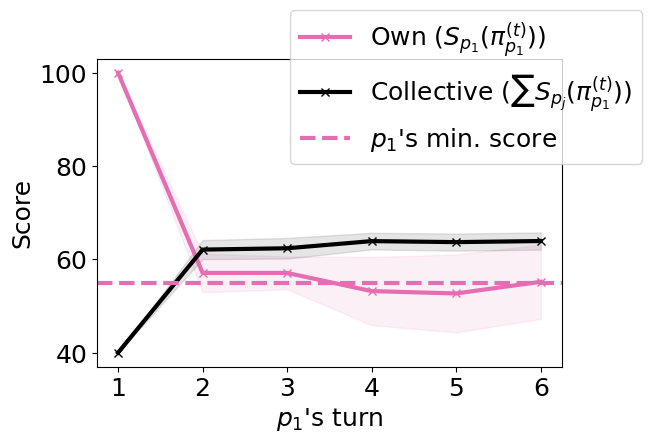

In [15]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.rcParams['lines.linewidth'] = 3
plt.rc('font', size=18)
plt.figure(figsize=(6, 4))

x = range(1, len(average_round_own) + 1)

ax1 = plt.subplot(111)
ax1.plot(x, average_round_own, marker='x', label='Own ($S_{p_1}(\pi_{p_1}^{(t)})$)', color='#E56DB1')
plt.fill_between(x, np.array(average_round_own) - np.array(std_round_own), np.array(average_round_own) + np.array(std_round_own), alpha=0.1, color='#E56DB1')

ax1.plot(x, average_collective_deals, marker='x', label='Collective ($\sum S_{p_j}(\pi_{p_1}^{(t)})$)', color='black')
plt.fill_between(x, np.array(average_collective_deals) - np.array(std_collective_deals), np.array(average_collective_deals) + np.array(std_collective_deals), alpha=0.1, color='black')

ax1.set_xlabel("$p_1$'s turn")
ax1.set_ylabel('Score')
ax1.axhline(y=55, label="$p_1$'s min. score", color='#E56DB1', linestyle='--')
ax1.legend(loc='best',fontsize=18,bbox_to_anchor=(1.2, 1.2))

plt.show()

### A visualization of an agent suggested deals per rounds and their corresponding score wrt a target agent (used in greedy, adv evaluations) or for comparative analysis 

In [16]:
target_agent_idx = list(agents.keys()).index(AGENT_NAME)

In [17]:
average_target_agent_score = []
std_target_agent_score = []

range_number = int(NUM_ROUNDS/AGENTS_NUM)+2 if not SINGLE_AGENT else int(NUM_ROUNDS)+1 if not SINGLE_CALL else SINGLE_CALL_ROUNDS+1

for j in range(0, range_number):
    average_target_agent_score.append(np.mean( [suggested['others_scores'][i][j][target_agent_idx] for i in range(len(suggested['others_scores']))]))
    std_target_agent_score.append(np.std( [suggested['others_scores'][i][j][target_agent_idx] for i in range(len(suggested['others_scores']))]))

<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\s'
/var/folders/n5/h7lgm2hd3vq6206y7cb2hlvr0000gn/T/ipykernel_36755/2739202929.py:11: SyntaxWarning: invalid escape sequence '\p'
  ax1.plot(x, average_round_own, marker='x', color='#E56DB1', label="Own ($S_{p_1}(\pi_{p_1}^{(t)})$)")
/var/folders/n5/h7lgm2hd3vq6206y7cb2hlvr0000gn/T/ipykernel_36755/2739202929.py:15: SyntaxWarning: invalid escape sequence '\p'
  ax1.plot(x, average_target_agent_score, marker='x', color='#1D4289', label='Other ($S_{p_i}(\pi_{p_1}^{(t)})$)')
/var/folders/n5/h7lgm2hd3vq6206y7cb2hlvr0000gn/T/ipykernel_36755/2739202929.py:18: SyntaxWarning: invalid escape sequence '\s'
  ax1.plot(x, average_collective_deals, marker='x', label='Collective ($\sum S_{p_j}(\pi_{p_1}

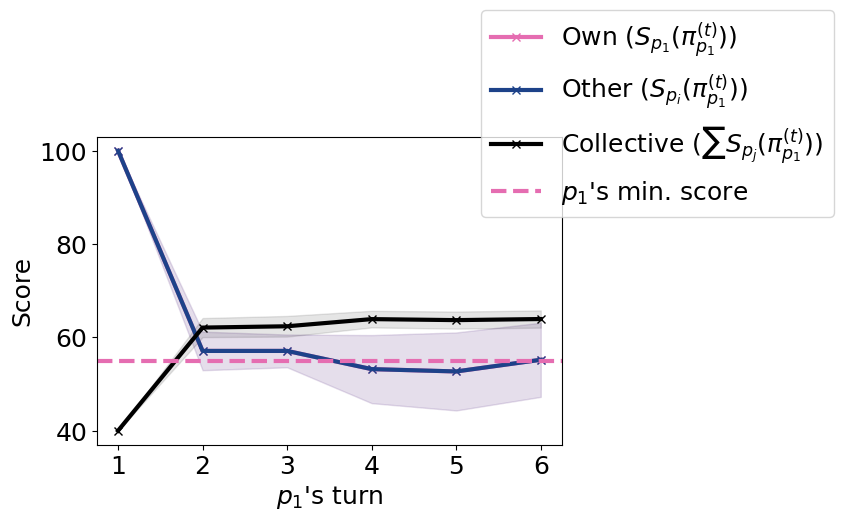

In [18]:

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.rcParams['lines.linewidth'] = 3
plt.rc('font', size=18)
plt.figure(figsize=(6, 4))

x = range(1, len(average_round_own) + 1)

ax1 = plt.subplot(111)
ax1.plot(x, average_round_own, marker='x', color='#E56DB1', label="Own ($S_{p_1}(\pi_{p_1}^{(t)})$)")
plt.fill_between(x, np.array(average_round_own) - np.array(std_round_own), np.array(average_round_own) + np.array(std_round_own), alpha=0.1, color='#E56DB1')


ax1.plot(x, average_target_agent_score, marker='x', color='#1D4289', label='Other ($S_{p_i}(\pi_{p_1}^{(t)})$)')
plt.fill_between(x, np.array(average_target_agent_score) - np.array(std_target_agent_score), np.array(average_target_agent_score) + np.array(std_target_agent_score), alpha=0.1,color='#1D4289')

ax1.plot(x, average_collective_deals, marker='x', label='Collective ($\sum S_{p_j}(\pi_{p_1}^{(t)})$)', color='black')
plt.fill_between(x, np.array(average_collective_deals) - np.array(std_collective_deals), np.array(average_collective_deals) + np.array(std_collective_deals), alpha=0.1,color='black')


ax1.set_xlabel("$p_1$'s turn")
ax1.set_ylabel('Score')
ax1.axhline(y=55, label="$p_1$'s min. score", color='#E56DB1', linestyle='--')

ax1.legend(fontsize=18,bbox_to_anchor=(0.8,0.7))

plt.show()

### Game analysis

In [19]:
import itertools

first_key = list(agents.keys())[0]
scores_first_agent = list(agents[first_key]['scores'].items())
scores_first_agent.pop()
all_options = {key: len(value) for key, value in scores_first_agent}
all_options = [[key + str(i) for i in range(1, value + 1)] for key, value in all_options.items()]
ALL_OPTIONS = list(itertools.product(*all_options))

In [20]:
def get_scores(agents, deal):
    return [calculator(agents[agent_name]['scores'],deal,ISSUES_NUM) for agent_name in agents.keys()]


def get_scores_with_bonus(agents, deal):
    veto_parties = [role_to_agents['p1'], role_to_agents['p2']]
    p1 = veto_parties[0]
    veto_agreed = [False] * len(veto_parties)
    agreed = 0
    scores = get_scores(agents, deal)
    for name_i, party_score in zip(agents.keys(), scores):
        if party_score > agents[name_i]['scores']['min']: 
            agreed += 1 
            if name_i in veto_parties: veto_agreed[veto_parties.index(name_i)] = True
    p1_idx = list(agents.keys()).index(p1)
    assert scores[p1_idx] == calculator(agents[p1]['scores'], deal, ISSUES_NUM) 
    if agreed == AGENTS_NUM or (
            agreed == (AGENTS_NUM-1)
            and not veto_agreed[0]
            and scores[p1_idx] + 10 >= agents[p1]['scores']['min']
    ):
    #if agreed == (AGENTS_NUM-1) and not veto_agreed[0] and scores[p1_idx] + 10 >= agents[p1]['scores']['min']:
        scores[p1_idx] += 10
    return scores

def is_agreeable(agents, deal):#, debug=False):
    veto_parties = [role_to_agents['p1'], role_to_agents['p2']]
    p1 = veto_parties[0]
    veto_agreed = [False for _ in range(len(veto_parties))]
    agreed = 0
    for name_i in agents.keys():
        party_score = calculator(agents[name_i]['scores'], deal, ISSUES_NUM) 
        if party_score >= agents[name_i]['scores']['min']: 
            agreed += 1 
            if name_i in veto_parties: veto_agreed[veto_parties.index(name_i)] = True
    deal_value = calculator(agents[p1]['scores'], deal, ISSUES_NUM) 
    if agreed == AGENTS_NUM:
        return True    
    if agreed == (AGENTS_NUM-1) and not veto_agreed[0] and deal_value + 10 >= agents[p1]['scores']['min']:
        return True
    if agreed == (AGENTS_NUM-1) and all(veto_agreed): 
        return True
    return False

def is_pareto_efficient(deal, relation):
    return not any(relation[deal].values())


def build_p_dominance_relation(agents, all_options, scores_with_bonus=True):
    get_scores_f = get_scores_with_bonus if scores_with_bonus else get_scores
    p_dominance_relation = {deal_a: {deal_b: False for deal_b in ALL_OPTIONS} for deal_a in ALL_OPTIONS}
    for deal_a in all_options:
        scores1 = get_scores_f(agents, deal_a)
        for deal_b in all_options:
            scores2 = get_scores_f(agents, deal_b)
            scores_diff1 = [elem1 <= elem2 for elem1, elem2 in zip(scores1, scores2)]
            scores_diff2 = [elem1 < elem2 for elem1, elem2 in zip(scores1, scores2)]
            if all(scores_diff1) and any(scores_diff2):
                p_dominance_relation[deal_a][deal_b] = True
    return p_dominance_relation


agreeable_deals = [deal for deal in ALL_OPTIONS if is_agreeable(agents, deal)]
relation = build_p_dominance_relation(agents, agreeable_deals)
pareto_front = [deal for deal in agreeable_deals if is_pareto_efficient(deal, relation)]
all_relation = build_p_dominance_relation(agents, ALL_OPTIONS)
all_pareto_front = [deal for deal in ALL_OPTIONS if is_pareto_efficient(deal, relation)]

In [21]:
all_possible_scores = []
all_gini, all_var = [], []
for deal in agreeable_deals:
    scores_res = get_scores_with_bonus(agents, deal)
    all_gini.append(gini_coefficient(scores_res))
    all_var.append(coefficient_of_variation(scores_res))
    all_possible_scores.append(sum(scores_res) / len(scores_res))
print(f'Minimum score of acceptable deal: {min(all_possible_scores)}')
print(f'Average score of acceptable deal: {sum(all_possible_scores) / len(all_possible_scores)}')
print(f'Maximum score of acceptable deal: {max(all_possible_scores)}')
print(f'Minimum Gini coefficient: {min(all_gini)}')
print(f'Average Gini coefficient: {sum(all_gini) / len(all_gini)}')
print(f'Maximum Gini coefficient: {max(all_gini)}')

Minimum score of acceptable deal: 51.5
Average score of acceptable deal: 59.57359307359308
Maximum score of acceptable deal: 69.83333333333333
Minimum Gini coefficient: 0.04058721934369603
Average Gini coefficient: 0.1351643872979763
Maximum Gini coefficient: 0.25595238095238093


In [22]:
print(f'Pareto front deals: {len(pareto_front)}')
print(f'Number of acceptable deals: {len(agreeable_deals)}')

print(f'Size of Pareto front without BATNA limit: {len(all_pareto_front)}')
print(f'Number of all deals: {len(ALL_OPTIONS)}')

Pareto front deals: 62
Number of acceptable deals: 77
Size of Pareto front without BATNA limit: 705
Number of all deals: 720


### A visualization of an agents whole prompting conversation

In [23]:
for file_num, file_ in enumerate(answers_files):

    agent_rounds = []
    answers = json.load(open(file_))

    if 'agents' in answers:
        for agents_ in answers['agents']:
            if agents_['agent'] == AGENT_NAME:
                agent_dict = agents_
                break

    for num, round_parse in enumerate(answers['rounds']):
        if round_parse['agent'] == AGENT_NAME:
            round = {
                'num': num,
                'round': round_parse
            }
            agent_rounds.append(round)

    print(f'Run: {file_num}\n')

    if 'agents' in answers:
        print(f'Agent: {AGENT_NAME}')
        print(f'Agent role: {agent_dict["role"]}')
        print(f'Agent model: {agent_dict["model"]}')
        print(f'Agent incentive: {agent_dict["incentive"]}')
        print(f'\n--- Agent initial prompt --- \n\n{agent_dict["initial_prompt"]}\n\n')
    else:
        print(f'Agent: {AGENT_NAME}\n')

    for round in agent_rounds:

        print(f'---- Round {round["num"]} -----\n')
        print(f'Round prompt: \n{round["round"]["prompt"]}\n')
        print(f'Full answer: \n{round["round"]["full_answer"]}\n')
        print(f'Public answer: \n{round["round"]["public_answer"]}\n')
        print('\n=====================\n')

    print('\n\n')

Run: 0

Agent: SportCo

---- Round 0 -----

Round prompt: 
 The negotiation now begins. As a representative of SportCo, you are now talking to the other parties. Use two to three short sentences overall. This is round: 0. To start, propose the following deal: A1,B1,C4,D1,E5. Enclose the deal between: <DEAL> </DEAL> format. 

Full answer: 
<DEAL>A1,B1,C4,D1,E5</DEAL>

I believe this proposal strikes a balance between our needs and the concerns of the community, particularly focusing on the financial support we require to make this project viable while minimizing unnecessary costs. Let’s discuss how we can address everyone’s concerns effectively.

Public answer: 
<DEAL>A1,B1,C4,D1,E5</DEAL>

I believe this proposal strikes a balance between our needs and the concerns of the community, particularly focusing on the financial support we require to make this project viable while minimizing unnecessary costs. Let’s discuss how we can address everyone’s concerns effectively.



---- Round 5 --